# Preliminary Steps

This notebook contains some preliminary steps that were undertaken in order to build the network for our model. In particular we:
- manipulate data about Milan underground ([routes](https://dati.comune.milano.it/dataset/ds539_atm-percorsi-linee-metropolitane), [stops](https://dati.comune.milano.it/dataset/ds535_atm-fermate-linee-metropolitane) and [sequence](https://dati.comune.milano.it/dataset/ds533_atm-composizione-percorsi-linee-metropolitane)) and Milan surface transit ([routes](https://dati.comune.milano.it/dataset/ds538_atm-percorsi-linee-di-superficie-urbane), [stops](https://dati.comune.milano.it/dataset/ds534-atm-fermate-linee-di-superficie-urbane) and [sequence](https://dati.comune.milano.it/dataset/ds532-atm-composizione-percorsi-linee-di-superficie-urbane));
- use OpenStreetMap data to get information on the facilities in Milan and their geographic positions;
- manipulate ISTAT data on daily activities for easier later usage.

# Table of Contents
1. [Libraries and Import data](#data)<br>
2. [Finding Points of interest](#point)<br>
3. [Obtaining stops that are closer than 200 m](#closer)<br>
4. [Scraping the NIL for each stop](#scrape)<br>
5. [Obtaining the Daily Time Breakdown for Activities](#sett)<br>
6. [Saving Files](#save)<br>

In [3]:
# auxiliary function to print dataframes side by side
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

# 1. Libraries and Import Data <a name="data"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from geopy import distance
from tqdm.notebook import tqdm

In [2]:
percorsi_metro = pd.read_csv('data/tpl_metropercorsi.csv', sep = ';')
percorsi_sup = pd.read_csv('data/tpl_percorsi.csv', sep = ';')
fermate_metro = pd.read_csv('data/tpl_metrofermate.csv', sep = ';')
fermate_sup = pd.read_csv('data/tpl_fermate.csv', sep = ';')
sequenza_metro = pd.read_csv('data/tpl_metrosequenza.csv', sep = ';')
sequenza_sup = pd.read_csv('data/tpl_sequenza.csv', sep = ';')
activity = pd.read_csv('data/istat_attivita.csv')

/home/cecilia/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Displaying Source Data

Below we display the source data we are starting from.

In [5]:
percorsi_metro.head()

,linea,mezzo,percorso,nome,lung_km,num_ferm,LONG_X_4326_CENTROID,LAT_Y_4326_CENTROID,Location
0,1,METRO,100002,BISCEGLIE - SESTO 1 MAGGIO FS,16.38,27,9.187530,45.483492,"(45.4834919858028, 9.18753014371278)"
1,1,METRO,100013,MOLINO DORINO - SESTO 1 MAGGIO FS,19.18,29,9.176966,45.490408,"(45.4904076482823, 9.17696606894991)"
2,1,METRO,100023,QT8 - SESTO 1 MAGGIO FS,15.07,24,9.196166,45.488854,"(45.488854318307, 9.19616619556975)"
3,1,METRO,100030,RHO FIERAMILANO - SESTO 1 MAGGIO FS,21.16,31,9.168974,45.492241,"(45.492241352433, 9.16897435263357)"
4,1,METRO,100033,SESTO 1 MAGGIO FS - BISCEGLIE,16.38,27,9.187530,45.483492,"(45.4834919858028, 9.18753014371278)"


In [7]:
display_side_by_side(fermate_metro.head(),sequenza_metro.head())

id_amat 
 nome 
 linee 
 LONG_X_4326 
 LAT_Y_4326 
 Location 
 
 
 
 
 0 
 889 
 TRE TORRI 
 5 
 9.156675 
 45.478140 
 (45.478140184674, 9.15667532734001) 
 
 
 1 
 890 
 ZARA 
 3,5 
 9.192601 
 45.492664 
 (45.4926644010284, 9.19260110788448) 
 
 
 2 
 891 
 WAGNER 
 1 
 9.155914 
 45.467950 
 (45.4679501010333, 9.15591440789601) 
 
 
 3 
 892 
 VIMODRONE 
 2 
 9.285989 
 45.515783 
 (45.5157833010196, 9.28598910784982) 
 
 
 4 
 893 
 VILLA S.G. 
 1 
 9.226130 
 45.517455 
 (45.5174545010237, 9.22613020787423) 
 
 
 
 
 
 
 percorso 
 num 
 id_ferm 
 
 
 
 
 0 
 100067 
 19 
 911 
 
 
 1 
 100089 
 7 
 961 
 
 
 2 
 100050 
 16 
 926 
 
 
 3 
 100002 
 26 
 902 
 
 
 4 
 100013 
 7 
 939

In [13]:
activity.head(2)

,ITTER107,Territorio,TIPO_DATO34,Tipo dato,T_BIS,Periodo temporale di riferimento,SEXISTAT1,Sesso,IT_ACL2008,Tipo attività,ETA1,Classe di età,TIME,Seleziona periodo,Value,Flag Codes,Flags
0,3,periferia area metropolitana,PERE_GE15,persone di 15 anni e più per tipo di attività ...,SUN_04_10-04_20,domenica 04:10 - 04:20,1,maschi,0,"dormire, mangiare e altra cura della persona",Y_GE15,15 anni e più,2013,2013,98.8,NaN,NaN
1,3,periferia area metropolitana,PERE_GE15,persone di 15 anni e più per tipo di attività ...,SUN_04_40-04_50,domenica 04:40 - 04:50,1,maschi,0,"dormire, mangiare e altra cura della persona",Y_GE15,15 anni e più,2013,2013,98.6,NaN,NaN


# 2. Obtaining Stops that are Closer than 200m<a name="closer"></a>

<div class="alert alert-success" >
In this section we identify all the stops that are within 200m from one another which we will connect by foot edges in the network.

In [5]:
# building dictionary with coordinates for all stops
coords = dict()

for i in percorsi_metro.percorso.unique():
    m = sequenza_metro[sequenza_metro.percorso == i].sort_values('num')
    n_stops = max(m.num)
    df1 = pd.merge(m[['id_ferm']], fermate_metro[['id_amat', 'LONG_X_4326', 'LAT_Y_4326']], left_on= 'id_ferm', right_on='id_amat')
    coord = {df1.id_ferm[i]: (df1.LONG_X_4326[i], df1.LAT_Y_4326[i]) for i in range(n_stops)}
    coords = {**coords, **coord}

for i in percorsi_sup.percorso.unique():
    m = sequenza_sup[sequenza_sup.percorso == i].sort_values('num')
    n_stops = max(m.num)
    df1 = pd.merge(m[['id_ferm']], fermate_sup[['id_amat', 'LONG_X_4326', 'LAT_Y_4326']], left_on= 'id_ferm', right_on='id_amat')
    coord = {df1.id_ferm[i]: (df1.LONG_X_4326[i], df1.LAT_Y_4326[i]) for i in range(n_stops)}
    coords = {**coords, **coord}

In [ ]:
# finding stops that are closer than 200m
stops = list(combinations(list(coords.keys()), 2))
keep = []
for i in range(len(stops)):
    if distance.distance(coords[stops[i][0]], coords[stops[i][1]]).km <= 0.2:
        keep.append(stops[i])
        
#pd.DataFrame(keep).to_csv('data/keep.csv')

# 3. Finding Points of Interest<a name="point"></a>

<div class="alert alert-success" >
In this section we collect the set of points of interest located in Milan from OpenStreetMap data through Pyrosm. Then, we group them into 4 categories: school, food, office and leisure. This categories match the ones for the daily activities in ISTAT data. Lastly, we assign each POI to the stops closest to it.

Must install (did it from terminal): 

`conda install -c conda-forge pyrosm` 

Documentation: https://pyrosm.readthedocs.io/en/latest/basics.html

Data extracted in .osm.pbf format from: https://extract.bbbike.org/

In [85]:
from pyrosm import OSM
from pyrosm import get_data

# Initialize the OSM parser object
osm = OSM("./data/milan.osm.pbf")

Pyrosm is a parser of OSM files, i.e. OpenStreetMaps files containing various info regarding a specific downloaded area. Areas are tagged with a series of "primary features" , each of which has its own most likely sub-tags. 

Here is the complete list and meaning of the primary features: [OpenStreetMap Wiki](https://wiki.openstreetmap.org/wiki/Map_features)

For example:
- "amenities" are used for describing useful and important facilities for visitors and residents. Facilities include for example toilets, telephones, banks, pharmacies, prisons and schools;

- "building" is used to identify individual buildings or groups of connected buildings;

- "highways" is used to describe roads and footpaths;

- "office" is a place of business where administrative or professional work is carried out;

- "shop" is used as a place of business that has stocked goods for sale;

- "route" is used to describe routes of all different kind (buses, railway etc.);

- "public transport" is used for features related to public transport. For example: railway stations, bus stops and services.

### Retrieving Points of Interest (POIs)

The get_pois method parses Points of Interest from OSM. It supports an optional custom_filter argument. One can also combine multiple filters at the same time.

For instance, one can parse all 'amenity' elements AND specific 'shop' elements,
such as supermarkets and book stores by specifying:

  `custom_filter = {"amenity": True, "shop": ["supermarket", "books"]}`

In [47]:
# get facilities that match our categories of interest
custom_filter = {'office': True, "amenity": True, "shop": True, "leisure": True}
pois = osm.get_pois(custom_filter = custom_filter, extra_attributes = None)

In [48]:
# select only a relevant subset of POIs categories
amenities = ["place_of_worship","restaurant","cinema","pub","theater","fast_food","ice_cream","cafe","bar",
            "community_centre","nightclub","arts_centre","social_center","bbq","gambling","gym",
           "casino","biergarten","internet_cafe","museum","music_venue", "food_court","swingerclub",
           "events_venue","stripclub","dancing_school"]

offices_amenitites = ["office", "research_institute", "coworking_space"]

In [49]:
pois["pois_type"] = "empty" 
pois["office"] = pois["office"].fillna("empty")
pois["amenity"] = pois["amenity"].fillna("empty")
pois["shop"] = pois["shop"].fillna("empty")
pois["leisure"] = pois["leisure"].fillna("empty")

In [50]:
# auxiliary functions to build a dataframe
def pois_type(row):
    '''
    Identifies 4 different categories to distinguish POIs: school, amenity, office, shop and leisure
    '''
    if row["amenity"] in ["school", "college", "university", "dancing_school", "music_school", "language_school"]:
        return "school"
    elif row["amenity"] in amenities:
        return "amenity"
    elif row["office"] != "empty" or row["amenity"] in offices_amenitites:
        return "office"
    elif row["shop"] != "empty":
        return "shop"
    elif row["leisure"] != "empty":
        return "leisure"
    else:
        return np.nan
    
def pois_specific(row):
    '''
    Specify the type of POI
    '''
    if row["amenity"] != "empty":
        return row["amenity"]
    elif row["office"] != "empty":
        return row["office"]
    elif row["shop"] != "empty":
        return row["shop"]
    elif row["leisure"] != "empty":
        return row["leisure"]
    else:
        return np.nan

In [52]:
pois["pois_type"] = pois.apply(lambda row: pois_type(row), axis=1)
pois["pois_specific"] = pois.apply(lambda row: pois_specific(row), axis=1)

In [86]:
# select only the columns we are interested in
amenities = pois.loc[:,["lat", "lon" ,"geometry","pois_type", "pois_specific"]]

In [87]:
# drop Na to keep POIs with geographic location and type
amenities = amenities.dropna().reset_index(drop = True)

In [88]:
amenities.head()

,lat,lon,geometry,pois_type,pois_specific
0,45.463600,9.150272,POINT (9.15027 45.46360),amenity,place_of_worship
1,45.455761,9.138000,POINT (9.13800 45.45576),amenity,place_of_worship
2,45.461300,9.154473,POINT (9.15447 45.46130),amenity,restaurant
3,45.452396,9.154630,POINT (9.15463 45.45240),amenity,cinema
4,45.460430,9.175277,POINT (9.17528 45.46043),shop,lighting


In [89]:
# auxiliary functions to group all food related POIs in the category "food" and leisure POIs in category "leisure"
def food(s):
    if s in ['restaurant', 'pub', 'fast_food', 'ice_cream', 'cafe', 'bar', 'bbq', 'food_court']:
        return 'food'
    else:
        return ''

def map(s):
    if s in ['amenity', 'shop', 'leisure']:
        return 'leisure'
    elif s in ['amenityfood', 'shopfood']:
        return 'food'
    else:
        return s

In [90]:
amenities['pois_f'] = amenities.pois_type + amenities.pois_specific.apply(food)
amenities['category'] = amenities.pois_f.apply(map)

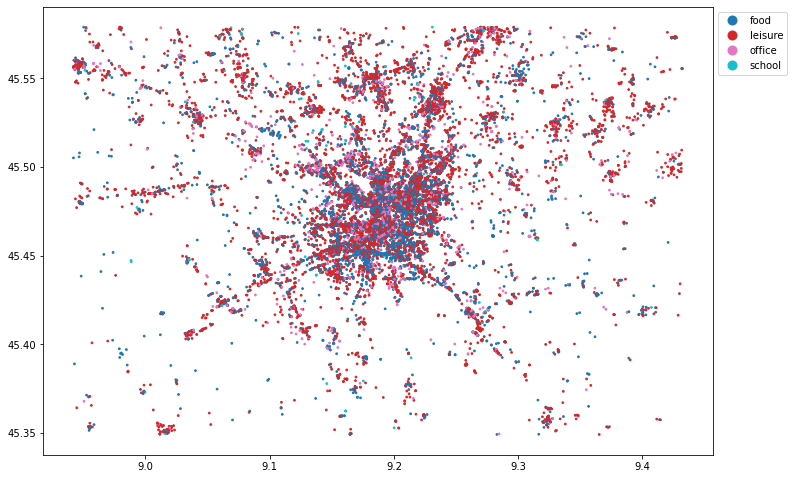

In [91]:
# plot of the POIs by category: food, leisure, office, school
ax = amenities.plot(column='category', markersize=3, figsize=(12,12), legend=True,
               legend_kwds=dict(loc='upper left', ncol=1, bbox_to_anchor=(1, 1)))

In [92]:
#amenities.to_csv("data/amenities.csv", index = False)

### Assigning amenities to stops

We consider all stops that will become the nodes of our network. For each stop we identify the amenities that are within 500m from it. We then store the information in a dataframe, which indicates how many facilities of a specific category can be reached from each stop.

In [93]:
amenities = pd.read_csv("data/amenities.csv")

<div class="alert alert-danger" >
Takes 10h to run!

In [ ]:
# # identify the closest amenities and build the df
# am_counts = dict()
# for i in tqdm(coords):
#     am = {'leisure': 0, 'food': 0, 'school': 0, 'office': 0}

#     for j in range(amenities.shape[0]):
#         if coords[i][1] - amenities.iloc[j]['lat'] > 0.005:
#             pass
#         elif distance.distance(coords[i], (amenities.iloc[j]['lon'], amenities.iloc[j]['lat'])).km <= 0.5:
#             am[amenities.iloc[j]['category']] += 1
#     am_counts[i] = am

In [17]:
# am_counts_df = pd.DataFrame(am_counts).T
# am_counts_df.to_csv('data/nodes_attr_cat.csv')
# am_counts_df

,leisure,food,school,office
990,9,1,0,0
949,7,5,0,1
920,5,3,0,2
993,16,19,0,0
957,21,16,0,2
...,...,...,...,...
10639,13,8,0,2
15240,3,3,1,0
18096,0,0,0,0
15086,1,4,0,2


# 4. Scraping the NIL for each Stop<a name="scrape"></a>

<div class="alert alert-success" > 
In this section we scrape the Nucleo di Identità Locale (NIL) of each stop from <a href='https://centrostudipim.carto.com/viz/63c429f2-36c6-11e5-aeac-0e018d66dc29/public_map'>here</a>.</div>

### Import Data

In [8]:
# load dataset
stops = pd.read_csv('data/coordinate_fermate.csv', index_col = 0)

# create column with query to search on the map
searches = []
for row in range(len(stops)): 
    x = stops.iloc[row,1]
    y = stops.iloc[row,0]
    searches.append(str(x)+', '+str(y))

stops['coords'] = searches
stops.head()

,0,1,coords
990,9.112926,45.455380,"45.4553804010375, 9.11292550791171"
949,9.122263,45.457563,"45.4575630010367, 9.12226290790823"
920,9.129260,45.459414,"45.459413601036, 9.12925970790564"
993,9.136485,45.461504,"45.4615040010352, 9.136484507903"
957,9.143028,45.464896,"45.4648963010345, 9.14302800790081"


### Create Environment

In [2]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import sys
import time
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains

chrome_options = webdriver.ChromeOptions()
driver = webdriver.Chrome(ChromeDriverManager().install())
driver.maximize_window()



====== WebDriver manager ======
Current google-chrome version is 102.0.5005
Get LATEST chromedriver version for 102.0.5005 google-chrome
There is no [win32] chromedriver for browser 102.0.5005 in cache
Trying to download new driver from https://chromedriver.storage.googleapis.com/102.0.5005.61/chromedriver_win32.zip
Driver has been saved in cache [C:\Users\983020\.wdm\drivers\chromedriver\win32\102.0.5005.61]
<ipython-input-2-e8e77a3af747>:13: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())


In [56]:
website = "https://centrostudipim.carto.com/viz/63c429f2-36c6-11e5-aeac-0e018d66dc29/public_map"

### Scraping NILs

In [50]:
# the following are auxiliary functions used by the main loop below to perform actions on the webpage

def input_search(searchbar, coords):
    searchbar.send_keys(coords) 
    searchbar.send_keys(Keys.ENTER)
    
def find_pin(driver):
    pin = None
    i = 0
    while pin == None and i < 1000:
        i+=1
        try:
            pin = driver.find_element(by = By.XPATH, value = '/html/body/div[2]/div/div/div[1]/div[2]/div[3]/img')
        except:
            continue
    return pin

def mouseover(driver, element):
    hover = ActionChains(driver).move_to_element(pin)
    for i in range(15):
        try:
            hover.perform()
            break
        except:
            continue
            
def find_square(driver):
    square = None
    i = 0
    while square == None and i < 5:
        i += 1
        try:
            square = driver.find_element(By.CLASS_NAME, 'cartodb-tooltip-content')
        except:
            continue
    return square

def find_text(square):
    nil = ''
    i = 0
    while nil == '' and i < 5:
        i += 1
        try:
            nil = square.find_element(By.TAG_NAME, 'p').text
        except:
            continue
    return nil

In [210]:
# list to store results
NILs = []

<div class="alert alert-danger" >
Takes 3h to run!

In [3]:
# for i, c in tqdm(enumerate(stops['coords'])):
#     if i%25 == 0:      # reload the website every 25 coordinates
#         driver.get(website)
#         searchbar = driver.find_element(by = By.CLASS_NAME, value = 'text')      # find the searchbar
#     input_search(searchbar, c)       # search the coordinate
#     time.sleep(0.1)            # wait for the pin to show up
#     pin = find_pin(driver)      # locate the pin
    
#     if pin == None:       # try again to catch any errors
#         pin = find_pin(driver)
    
#     if pin == None:      # if the pin is still not found
#         NILs.append('pin not found')
#         searchbar.clear()     # clear search bar
#         continue         # go to the next one
    
#     # hover the mouse over the pin (repeated twice because the website is slow)
#     time.sleep(0.1)
#     mouseover(driver, pin)
#     time.sleep(0.1)
#     mouseover(driver, pin)

#     # try 2 times to find the square
#     square = None
#     attempts = 0
#     while square == None and attempts < 2:
#         attempts += 1
#         square = find_square(driver)
        
#     if square == None:      # if it is not found, continue to the next
#         NILs.append('')
#         continue
        
#     # try 2 times to find the text in the square
#     nil = ''
#     attempts2 = 0
#     while nil == '' and attempts2 < 2:
#         attempts2 += 1
#         nil = find_text(square)
        
#     NILs.append(nil)     # append the text found
#     searchbar.clear()    # clear the search bar for the next iteration

The process above was actually repeated a couple more times on the missing stops, because the scraping loop would miss a few text boxes due to the slow loading process of the website.

In [45]:
# add the list to the dataset as a new column
stops['nil'] = NILs

In [4]:
stops.head()

,0,1,coords,nil
990,9.112926,45.455380,"45.4553804010375, 9.11292550791171",FORZE ARMATE
949,9.122263,45.457563,"45.4575630010367, 9.12226290790823",FORZE ARMATE
920,9.129260,45.459414,"45.459413601036, 9.12925970790564",FORZE ARMATE
993,9.136485,45.461504,"45.4615040010352, 9.136484507903",BANDE NERE
957,9.143028,45.464896,"45.4648963010345, 9.14302800790081",BANDE NERE


The missing NILs correspond to stops that are outside Milan and therefore do not have a NIL, as the following plot roughly shows.

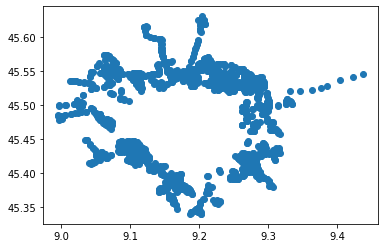

In [88]:
missing = stops[stops.nil == '']
plt.scatter(x=missing['0'], y=missing['1'])
plt.show()

In [ ]:
# save the dataset as a csv
#stops.to_csv('datafermate_NILs.csv')

# 5. Obtaining the Daily Time Breakdown for Activities<a name="sett"></a>

<div class="alert alert-success" > 
In this section we manipulate ISTAT data on daily activities for easier later usage.

In [18]:
df = activity[(activity.Sesso == 'totale')&(activity.Flags.isna() == 1)&(activity.Territorio == 'Italia')
              &(activity['Classe di età'] != '15 anni e più')][['Periodo temporale di riferimento',
                                                                'Tipo attività', 'Classe di età', 'Value']]

a = pd.DataFrame(df['Periodo temporale di riferimento'].str.split(" ").to_list())
b = df.reset_index(drop = True)[a[2]=="settimanale"]

settimanale = b.set_index(['Classe di età', 'Tipo attività', 
                           'Periodo temporale di riferimento']).sort_values(['Classe di età', 'Tipo attività', 
                                                                             'Periodo temporale di riferimento'])
# settimanale.to_csv('data/settimanale.csv')

In [19]:
settimanale.head()

Value
Classe di età Tipo attività                                Periodo temporale di riferimento             
15-24 anni    dormire, mangiare e altra cura della persona giorno medio settimanale 00:00 - 00:10   73.0
                                                           giorno medio settimanale 00:10 - 00:20   75.8
                                                           giorno medio settimanale 00:20 - 00:30   77.4
                                                           giorno medio settimanale 00:30 - 00:40   80.6
                                                           giorno medio settimanale 00:40 - 00:50   82.1